# Building a Collaborative-Filtering Recommendation system for recommending classes to students

## In this article, we will build a collaborative-filtering recommendation system that will use the ratings from similar users recommend them various classes

A Recommendation System, in simpler terms is basically a filtering system that aims to predict a rating or preference that a user would give to a particular item, which in our case are classes.

![title](main.png)

There are various types of algorithms used in building Recommendation systems such as Rank Based, Content Based, Collaborative Filtering, Matrix Factorization and many more. Content Based and Collaborative Filtering are the most common ones among these. In this article, we will look into collaborative filtering to recommend classes to the students.

## Exploratory Data Analysis

First, let's create a dummy dataset.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(123)

users_df = pd.DataFrame(columns=['User ID', 'Class ID', 'Class Name', 'Rating'])

file = open('course_names.txt', 'r')
course_names = []
for line in file.readlines():
    if(line and 'CATEGORY' not in line):
        course_name = line.strip()
        while(True):
            try:
                _ = int(course_name[-1])
                course_name = course_name.replace(course_name[-1], '')
            except:
                course_names.append(course_name.strip())
                break
        
course_names

user_ids = list(range(30))
class_ids = list(range(175))

for user_id in user_ids:
    for class_id in class_ids:
        if_rating = random.randint(0, 1)
        if(if_rating):
            rating = random.randint(1, 10)
        else:
            rating = 0
        series = [user_id, class_id, course_names[class_id], rating]
        users_df.loc[len(users_df)] = series

In [27]:
users_df

,User ID,Class ID,Class Name,Rating
0,0,0,Algorithms of the Intelligent Web,0
1,0,1,Data Science Algorithms in a Week,2
2,0,2,Jupyter for Data Science,5
3,0,3,Machine Learning with R Cookbook,0
4,0,4,Machine Learning Cookbook,0
...,...,...,...,...
5245,29,170,Cloud Analytics with Microsoft Azure,2
5246,29,171,Machine Learning on Google Cloud Platform,10
5247,29,172,Machine Learning with AWS,6
5248,29,173,Machine Learning for Cybersecurity,4


Let's first start by conducting EDA on our data to get a better understanding of what we are dealing with. 


Here we have two separate dataframes. The first dataframe contains the rating a user gave to a class. The rating varies from 1–10 and 0 shows that the user hasn't attended that class. The other dataframe just contains the class ids that we have. We have 30 users and classes, thus total 900 rows in the dataframe.

Lets group the data by ratings and see the average ratings that the users give. We will use the following data for that

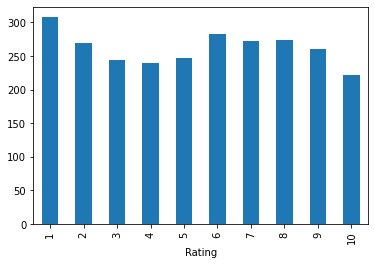

In [28]:
def plot_ratings(df):
    actual_ratings = df[users_df['Rating'] != 0]
    count_ratings = actual_ratings.groupby('Rating').count()['User ID']
    count_ratings.plot.bar()
    
plot_ratings(users_df)

## User-Based Collaborative Filtering

There are different types of collaborative filtering algorithms, mainly item-based and user-based. In this article, we are going to be using user-based collaborative filtering.


User-Based Collaborative filtering basically utilizes the assumption that generally people with similar characteristics share similar interests. In our case, it would mean that if two students have highly rated similar classes in the past, we can recommend them classes that are highly rated by one student to the other as it makes sense that they will highly rate those classes in the future as well.


### Creating User Item Matrix


For this, we will first create a user-item matrix (in our case student-class) where the rows and columns will be the student and class ids respectively. If a student has given a class a rating, we will place ‘the rating’ there and ‘0’ if they have not.


In [30]:
def create_user_item_matrix(df):
    user_item = users_df.groupby(['User ID', 'Class ID'])['Rating'].unique().unstack()
    
    #to convert list to integer ratings
    for i in range(len(class_ids)):
        for j in range(len(user_ids)):
            user_item[i][j] = user_item[i][j][0]
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(users_df)

In [34]:
user_item.head()

Class ID,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
User ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,5,0,0,9,6,0,0,0,...,9,10,0,7,0,0,5,0,6,1
1,0,3,0,0,9,0,0,8,4,9,...,5,0,4,1,2,0,0,0,0,0
2,10,0,10,9,2,0,0,1,1,0,...,2,9,0,8,0,0,10,0,0,7
3,0,0,5,0,0,4,0,4,1,0,...,0,0,0,7,0,10,4,5,10,8
4,9,3,8,0,0,0,1,7,4,0,...,0,4,0,0,5,0,10,0,0,3


### Get Classes attended by Users

Now, we will write a function that will return the classes attended by a user and sort them by the ratings. We do this because after getting the similar users, we will recommend the classes attended by the most similar user with the highest rating to that particular user

In [35]:
def get_classes_attended_by_user(user_id, df):
    attended_df = df[(df['User ID'] == user_id) & (df['Rating'] != 0)]
    return list(attended_df.sort_values(by='Rating', ascending=False)['Class ID'])

### Getting Similar Users

Now we will work on getting users similar to particular user. This is done by comparing the ratings given by the two users to a class attended by both of them. We will calculate the total ratings and return the users with the highest total ratings.

In [36]:
def get_similar_users(user_id, df):
    similar_users = user_item.dot(user_item[user_item.index == user_id].T)
    user_interactions  = users_df[users_df['Rating'] != 0].groupby('User ID', sort=False).count()['Class ID']
    neighbors_df = pd.merge(similar_users, user_interactions, how='left', left_index=True, right_index=True)
    neighbors_df = neighbors_df.reset_index()
    neighbors_df.columns = ['neighbor_id', 'similarity','interactions']
    neighbors_df = neighbors_df.sort_values(['similarity','interactions'],ascending=False)
    
    return neighbors_df

There's a lot going on in this function. Let's break it down a bit:

1. It starts with computing the dot product of the user with `user_id` with all other users. Higher dot product means that the users gave similar high ratings to the same classes.
2. `user_interactions` contain data regarding the number of classes each user has attended.
3. We merge the `similar_users` with `user_interactions` and sort it first by the similarity and if its same, then use the one with more interactions.

This is what we get when we run this function for `user_id` 1:

In [39]:
get_similar_users(1, users_df)

,neighbor_id,similarity,interactions
1,1,2015,79
26,26,1089,90
16,16,1082,86
14,14,1043,88
10,10,1035,89
11,11,1015,95
25,25,1007,100
29,29,976,95
2,2,973,93
28,28,965,88


### Get class titles

Lets create a function that accepts an array of class ids and returns the titles of those classes

In [10]:
course_names[0]

'Algorithms of the Intelligent Web'

In [11]:
def get_class_titles(class_ids):
    return [course_names[int(i)] for i in class_ids]

### Providing Recommendations

Finally, we will combine all of this to recommend classes to users.

In [12]:
def user_recs(user_id, n_recs=10):
  
    recs = []
    neighbors_df = get_similar_users(user_id, users_df)
    neighbor_user_ids = neighbors_df['neighbor_id'].values
    classes_attended_user = get_classes_attended_by_user(user_id, users_df)
    for neighbor_id in neighbor_user_ids:
        classes_attended_other = get_classes_attended_by_user(neighbor_id, users_df)
        new_recs = np.setdiff1d(classes_attended_other, classes_attended_user)
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
# If we have enough recommendations exit the loop
        if len(recs) > n_recs-1:
            recs = recs[:n_recs]
            break
            
            
            
    return get_class_titles(recs)



The function executes as follows:

1. We get the most similar users based on ratings on classes using the function `get_similar_users` 
2. We get the classes attended by the current user.
3. We iterate through the ids of similar users and append the classes not yet attended by the current user to the total recommendations.
4. If we reach the number of recommendations we want, we exit the loop

Let's test this function:

In [16]:
user_recs(1)

['Machine Learning with R Cookbook',
 'Machine Learning Cookbook',
 'Real-time Data Processing and Analytics',
 'Large Scale Machine Learning with Python',
 'Integrating Hadoop',
 'Keras 2.x Projects',
 'Jupyter Cookbook',
 'Build a Career in Data Science',
 'Machine Learning for Finance',
 'Go Machine Learning Projects']

In [17]:
user_recs(10)

['Java for Data Science',
 'Learning Social Media Analytics with R',
 'Apache Spark .x Machine Learning Cookbook',
 'R Machine Learning Projects',
 'Exploratory Analysis with pandas',
 'Turning Text into Gold: Taxonomies and Textual Analytics',
 'Machine Learning for Algorithmic Trading',
 'Python Machine Learning Blueprints',
 'Data Analysis and Business Modeling with Excel 201',
 'Go Machine Learning Projects']

In [18]:
user_recs(29)

['Jupyter for Data Science',
 'Machine Learning with R Cookbook',
 'Machine Learning Cookbook',
 'Python for Finance',
 'Machine Learning Solutions',
 'Turning Text into Gold: Taxonomies and Textual Analytics',
 'Intelligent Mobile Projects with TensorFlow',
 'Jupyter Cookbook',
 'Machine Learning for Mobile',
 'Data Science Boot camp']

As we can see, the function successfully recommends the top 10 classes the user is most likely to give a higher rating to.

## Conclusion

In this article, we looked into collaborative-filtering based recommendation systems:
    
1. We saw the importance of creating user-item matrix and using dot product of ratings as a means to calculate the similarity between different users
2. We built a recommendation system using the information we had regarding the ratings users give to various classes they had attended
3. We calculated the similar users and recommended the highest rated classes not yet attended by the current user.